## 基于文本挖掘的企业隐患排查质量分析模型

### 赛题背景
企业自主填报安全生产隐患,对于将风险消除在事故萌芽阶段具有重要意义.企业在填报隐患时,往往存在不认真填报的情况,“虚报、假报”隐患内容,增大了企业监管的难度.
采用大数据手段分析隐患内容,找出不切实履行主体责任的企业,向监管部门进行推送,实现精准执法,能够提高监管手段的有效性,增强企业安全责任意识

### 数据说明

训练集数据包含"id、level_1（一级标准）、level_2（二级标准）、level_3（三级标准）、level_4（四级标准）、content（隐患内容）和label（标签）”共7个字段.
其中“id”为主键,无业务意义;“一级标准、二级标准、三级标准、四级标准”为《深圳市安全隐患自查和巡查基本指引（2016年修订版）》规定的排查指引,一级标准对应不同隐患类型,
二至四级标准是对一级标准的细化,企业自主上报隐患时,根据不同类型隐患的四级标准开展隐患自查工作;“隐患内容”为企业上报的具体隐患;“标签”标识的是该条隐患的合格性,
“1”表示隐患填报不合格,“0”表示隐患填报合格.

In [86]:
from transformers import AutoModel, AutoTokenizer, AutoConfig, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
import random

In [87]:
def set_seed(seed):
    """PyTorch随机数种子设置大全"""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)  # CPU上设置随机种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # 当前GPU上设置随机种子
        # torch.cuda.manual_seed_all(seed) # 所有GPU上设置随机种子


RANDOM_SEED = 42
set_seed(RANDOM_SEED)

In [89]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [91]:
train = pd.read_csv('./data/train.csv')  # 训练数据集
test = pd.read_csv('data/test.csv')  # 测试数据集
sub = pd.read_csv('data/train.csv')  # 验证数据集

print('train.shape=', train.shape)
print('test.shape=', test.shape)
print('sub.shape=', sub.shape)

train.shape= (12000, 7)
test.shape= (18000, 6)
sub.shape= (12000, 7)


In [96]:
train.head(3)

,id,level_1,level_2,level_3,level_4,content,label
0,0,工业/危化品类（现场）—2016版,（二）电气安全,6、移动用电产品、电动工具及照明,1、移动使用的用电产品和I类电动工具的绝缘线，必须采用三芯(单相)或四芯(三相)多股铜芯橡套软线。,"使用移动手动电动工具,外接线绝缘皮破损,应停止使用.",0
1,1,工业/危化品类（现场）—2016版,（一）消防检查,1、防火巡查,3、消防设施、器材和消防安全标志是否在位、完整；,一般,1
2,2,工业/危化品类（现场）—2016版,（一）消防检查,2、防火检查,6、重点工种人员以及其他员工消防知识的掌握情况；,消防知识要加强,0


In [99]:
train.info()  # content列缺失值数为2

train[train['content'].isna()]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       12000 non-null  int64 
 1   level_1  12000 non-null  object
 2   level_2  12000 non-null  object
 3   level_3  12000 non-null  object
 4   level_4  12000 non-null  object
 5   content  11998 non-null  object
 6   label    12000 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 656.4+ KB


,id,level_1,level_2,level_3,level_4,content,label
6193,6193,工业/危化品类（现场）—2016版,（一）消防检查,1、防火巡查,3、消防设施、器材和消防安全标志是否在位、完整；,NaN,1
9248,9248,工业/危化品类（现场）—2016版,（一）消防检查,1、防火巡查,4、常闭式防火门是否处于关闭状态，防火卷帘下是否堆放物品影响使用；,NaN,1


In [100]:
test.info()  # content列缺失值数为4
test[test['content'].isna()]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       18000 non-null  int64 
 1   level_1  18000 non-null  object
 2   level_2  18000 non-null  object
 3   level_3  18000 non-null  object
 4   level_4  18000 non-null  object
 5   content  17996 non-null  object
dtypes: int64(1), object(5)
memory usage: 843.9+ KB


,id,level_1,level_2,level_3,level_4,content
970,970,工业/危化品类（现场）—2016版,（一）消防检查,1、防火巡查,3、消防设施、器材和消防安全标志是否在位、完整；,NaN
13006,13006,工业/危化品类（现场）—2016版,（一）消防检查,1、防火巡查,3、消防设施、器材和消防安全标志是否在位、完整；,NaN
16845,16845,工业/危化品类（现场）—2016版,（一）消防检查,1、防火巡查,3、消防设施、器材和消防安全标志是否在位、完整；,NaN
17742,17742,商贸服务教文卫类（现场）—2016版,（二）电气安全,1、配电房,2、配电房内电缆线应放置在电缆沟内，并应加设盖板。配电柜前后面应放置绝缘垫，其绝缘垫的长度应...,NaN


0    10712
1     1288
Name: label, dtype: int64


Text(0.5, 0, 'label count')

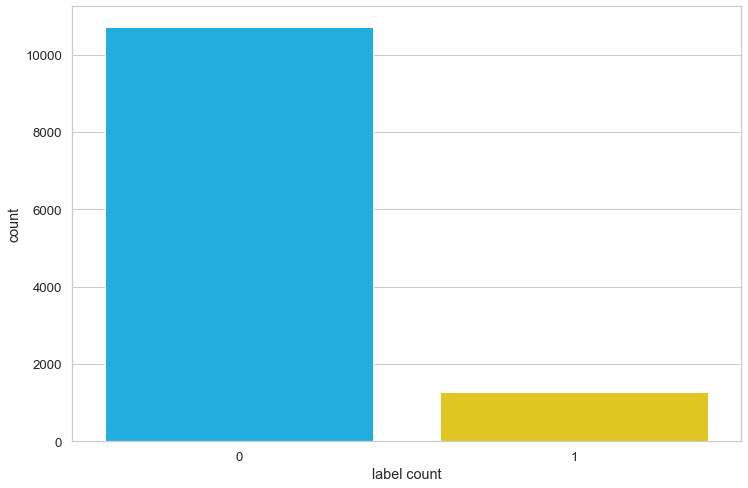

In [104]:
print(train['label'].value_counts())

sns.countplot(data=train, x='label')
plt.xlabel('label count')

In [105]:
# 填充缺失值
train['content'] = train['content'].fillna('空值')
test['content'] = test['content'].fillna('空值')

In [115]:
train['level_1'] = train['level_1'].apply(lambda x: x.split('（')[0])
train['level_2'] = train['level_2'].apply(lambda x: x.split('）')[-1])
train['level_3'] = train['level_3'].apply(lambda x: re.split(r'[0-9]、', x)[-1])
train['level_4'] = train['level_4'].apply(lambda x: re.split(r'[0-9]、', x)[-1])

test['level_1'] = test['level_1'].apply(lambda x: x.split('（')[0])
test['level_2'] = test['level_2'].apply(lambda x: x.split('）')[-1])
test['level_3'] = test['level_3'].apply(lambda x: re.split(r'[0-9]、', x)[-1])
test['level_4'] = test['level_4'].apply(lambda x: re.split(r'[0-9]、', x)[-1])

In [117]:
train.head(3)

,id,level_1,level_2,level_3,level_4,content,label
0,0,工业/危化品类,电气安全,移动用电产品、电动工具及照明,移动使用的用电产品和I类电动工具的绝缘线，必须采用三芯(单相)或四芯(三相)多股铜芯橡套软线。,"使用移动手动电动工具,外接线绝缘皮破损,应停止使用.",0
1,1,工业/危化品类,消防检查,防火巡查,消防设施、器材和消防安全标志是否在位、完整；,一般,1
2,2,工业/危化品类,消防检查,防火检查,重点工种人员以及其他员工消防知识的掌握情况；,消防知识要加强,0


In [118]:
train['text'] = train['content'] + '[SEP]' + train['level_1'] + '[SEP]' + train['level_2'] + '[SEP]' + train[
    'level_3'] + '[SEP]' + train['level_4']
test['text'] = test['content'] + '[SEP]' + test['level_1'] + '[SEP]' + test['level_2'] + '[SEP]' + test[
    'level_3'] + '[SEP]' + test['level_4']

In [119]:
train.head(3)

,id,level_1,level_2,level_3,level_4,content,label,text
0,0,工业/危化品类,电气安全,移动用电产品、电动工具及照明,移动使用的用电产品和I类电动工具的绝缘线，必须采用三芯(单相)或四芯(三相)多股铜芯橡套软线。,"使用移动手动电动工具,外接线绝缘皮破损,应停止使用.",0,"使用移动手动电动工具,外接线绝缘皮破损,应停止使用.[SEP]工业/危化品类[SEP]电气安..."
1,1,工业/危化品类,消防检查,防火巡查,消防设施、器材和消防安全标志是否在位、完整；,一般,1,一般[SEP]工业/危化品类[SEP]消防检查[SEP]防火巡查[SEP]消防设施、器材和消...
2,2,工业/危化品类,消防检查,防火检查,重点工种人员以及其他员工消防知识的掌握情况；,消防知识要加强,0,消防知识要加强[SEP]工业/危化品类[SEP]消防检查[SEP]防火检查[SEP]重点工种...


In [121]:
train['text_len'] = train['text'].map(len)
test['text_len'] = test['text'].map(len)

In [123]:
train['text_len'].describe()

count    12000.000000
mean        80.439833
std         21.913662
min         43.000000
25%         66.000000
50%         75.000000
75%         92.000000
max        298.000000
Name: text_len, dtype: float64

In [125]:
test['text_len'].describe()

count    18000.000000
mean        80.762611
std         22.719823
min         43.000000
25%         66.000000
50%         76.000000
75%         92.000000
max        520.000000
Name: text_len, dtype: float64

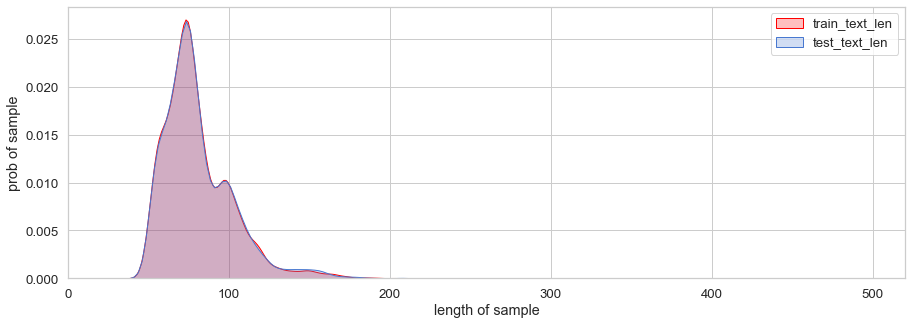

In [128]:
# 观察训练数据集与测试数据集分布情况(分布基本一直)
plt.figure(figsize=(15, 5))
ax = plt.subplot(111)
sns.kdeplot(train['text_len'], ax=ax, color='red', fill=True)
sns.kdeplot(test['text_len'], ax=ax, color='b', fill=True)
ax.set_xlim([0, max(max(train['text_len']), max(test['text_len']))])
plt.xlabel("length of sample")
plt.ylabel("prob of sample")
plt.legend(['train_text_len', 'test_text_len'])

In [133]:
# 文本长度大部分在166以内
np.percentile(train['text_len'], q=99.5)

166.0

In [136]:
PRE_TRAINED_MODEL_NAME = 'bert-base-chinese'
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
tokenizer

PreTrainedTokenizerFast(name_or_path='bert-base-chinese', vocab_size=21128, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [53]:
MAX_LEN = 166

In [54]:
class EnterpriseDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        """
        item 为数据索引，迭代取第item条数据
        """
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        #         print(encoding['input_ids'])
        return {
            'texts': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            # toeken_type_ids:0
            'labels': torch.tensor(label, dtype=torch.long)
        }


### 5.2 划分数据集并创建生成器

In [55]:
df_train, df_test = train_test_split(train, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
df_train.shape, df_val.shape, df_test.shape

((10800, 9), (600, 9), (600, 9))

In [56]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = EnterpriseDataset(
        texts=df['text'].values,
        labels=df['label'].values,
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        #         num_workers=4 # windows多线程
    )

In [57]:
BATCH_SIZE = 4

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [58]:
next(iter(train_data_loader))

C:\Users\dcdmm\anaconda3\envs\pytorch_env\lib\site-packages\transformers\tokenization_utils_base.py:2271: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


{'texts': ['指示标识不清楚[SEP]工业/危化品类[SEP]消防检查[SEP]防火巡查[SEP]安全出口、疏散通道是否畅通，安全疏散指示标志、应急照明是否完好；',
  '发现本月有灭火器过期，已安排购买灭火器更换[SEP]商贸服务教文卫类[SEP]消防检查[SEP]防火检查[SEP]灭火器材配置及有效情况。',
  '安全出口标志灯有一个有故障，已买回安装改正。[SEP]工业/危化品类[SEP]消防检查[SEP]防火巡查[SEP]安全出口、疏散通道是否畅通，安全疏散指示标志、应急照明是否完好；',
  '堵了消防通道[SEP]工业/危化品类[SEP]消防检查[SEP]防火巡查[SEP]安全出口、疏散通道是否畅通，安全疏散指示标志、应急照明是否完好；'],
 'input_ids': tensor([[ 101, 2900, 4850, 3403, 6399,  679, 3926, 3504,  102, 2339,  689,  120,
          1314, 1265, 1501, 5102,  102, 3867, 7344, 3466, 3389,  102, 7344, 4125,
          2337, 3389,  102, 2128, 1059, 1139, 1366,  510, 4541, 3141, 6858, 6887,
          3221, 1415, 4517, 6858, 8024, 2128, 1059, 4541, 3141, 2900, 4850, 3403,
          2562,  510, 2418, 2593, 4212, 3209, 3221, 1415, 2130, 1962, 8039,  102,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0

In [59]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['texts', 'input_ids', 'attention_mask', 'labels'])

In [60]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['labels'].shape)

torch.Size([4, 160])
torch.Size([4, 160])
torch.Size([4])


In [ ]:
bert_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [71]:
class EnterpriseDangerClassifier(nn.Module):
    def __init__(self, n_classes):
        super(EnterpriseDangerClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)  # 两个类别

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False
        )
        output = self.drop(pooled_output)  # dropout
        return self.out(output)

In [72]:
class_names = [0, 1]

In [73]:
model = EnterpriseDangerClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [74]:
data

{'texts': ['指示标识不清楚[SEP]工业/危化品类[SEP]消防检查[SEP]防火巡查[SEP]安全出口、疏散通道是否畅通，安全疏散指示标志、应急照明是否完好；',
  '发现本月有灭火器过期，已安排购买灭火器更换[SEP]商贸服务教文卫类[SEP]消防检查[SEP]防火检查[SEP]灭火器材配置及有效情况。',
  '安全出口标志灯有一个有故障，已买回安装改正。[SEP]工业/危化品类[SEP]消防检查[SEP]防火巡查[SEP]安全出口、疏散通道是否畅通，安全疏散指示标志、应急照明是否完好；',
  '堵了消防通道[SEP]工业/危化品类[SEP]消防检查[SEP]防火巡查[SEP]安全出口、疏散通道是否畅通，安全疏散指示标志、应急照明是否完好；'],
 'input_ids': tensor([[ 101, 2900, 4850, 3403, 6399,  679, 3926, 3504,  102, 2339,  689,  120,
          1314, 1265, 1501, 5102,  102, 3867, 7344, 3466, 3389,  102, 7344, 4125,
          2337, 3389,  102, 2128, 1059, 1139, 1366,  510, 4541, 3141, 6858, 6887,
          3221, 1415, 4517, 6858, 8024, 2128, 1059, 4541, 3141, 2900, 4850, 3403,
          2562,  510, 2418, 2593, 4212, 3209, 3221, 1415, 2130, 1962, 8039,  102,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0

In [75]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape)  # batch size x seq length
print(attention_mask.shape)  # batch size x seq length

torch.Size([4, 160])
torch.Size([4, 160])


In [76]:
model(input_ids, attention_mask)

tensor([[ 0.2120, -0.4050],
        [ 0.3156, -0.4160],
        [ 0.5127, -0.4634],
        [ 0.3168,  0.5057]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [77]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.4999, 0.5001],
        [0.5258, 0.4742],
        [0.5899, 0.4101],
        [0.4575, 0.5425]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

## 7 模型训练

In [78]:
EPOCHS = 10  # 训练轮数

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

C:\Users\dcdmm\anaconda3\envs\pytorch_env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [79]:
def train_epoch(
        model,
        data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        n_examples
):
    model = model.train()  # train模式
    losses = []
    correct_predictions = 0
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["labels"].to(device)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions.double() / n_examples, np.mean(losses)

In [80]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()  # 验证预测模式

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)


In [81]:

history = defaultdict(list)  # 记录10轮loss和acc
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc


Epoch 1/10
----------
Train loss 0.498337963949544 accuracy 0.8903703703703704
Val   loss 0.4272330579161644 accuracy 0.9

Epoch 2/10
----------


KeyboardInterrupt: 

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
# model = EnterpriseDangerClassifier(len(class_names))
# model.load_state_dict(torch.load('best_model_state.bin'))
# model = model.to(device)

## 8 模型评估

In [ ]:
test_acc, _ = eval_model(
    model,
    test_data_loader,
    loss_fn,
    device,
    len(df_test)
)

test_acc.item()

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    raw_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["texts"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)  # 类别

            probs = F.softmax(outputs, dim=1)  # 概率

            raw_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return raw_texts, predictions, prediction_probs, real_values


In [ ]:
y_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=[str(label) for label in class_names]))  # 分类报告

In [ ]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True label')
    plt.xlabel('Predicted label');


cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)


In [ ]:
idx = 2

sample_text = y_texts[idx]
true_label = y_test[idx]
pred_df = pd.DataFrame({
    'class_names': class_names,
    'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(sample_text)))
print()
print(f'True label: {class_names[true_label]}')

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

## 9 测试集预测

In [ ]:
sample_text = "电源插头应按规定正确接线"

In [ ]:
encoded_text = tokenizer.encode_plus(
    sample_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

In [ ]:
input_ids = encoded_text['input_ids'].to(device)
attention_mask = encoded_text['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Sample text: {sample_text}')
print(f'Danger label  : {class_names[prediction]}')